<a href="https://colab.research.google.com/github/luzots/DIO_ML_P5/blob/main/DIO_Lab5_RecoFacial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics
!pip install opencv-python
!pip install numpy
!pip install deepface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

Saving IMG_20230122_150536486_HDR.jpeg to IMG_20230122_150536486_HDR (4).jpeg


<IPython.core.display.Javascript object>


0: 480x640 1 person, 157.2ms
Speed: 3.0ms preprocess, 157.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


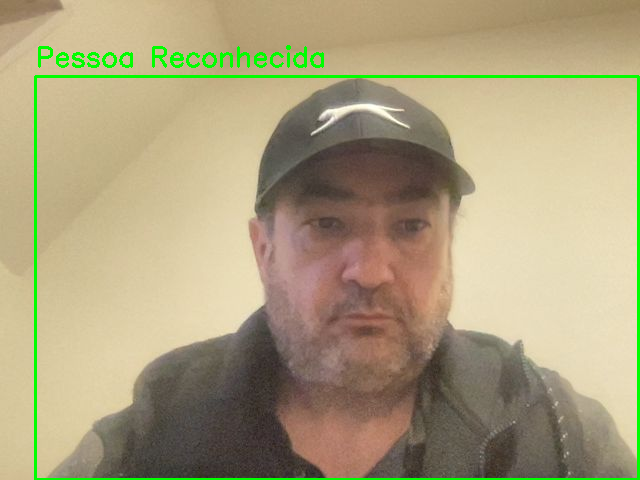

In [17]:


from ultralytics import YOLO
import cv2
import numpy as np
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from google.colab.patches import cv2_imshow
from deepface import DeepFace
import os
import tempfile

# Carregar o modelo YOLOv8 Nano
model = YOLO('yolov8n.pt')

# Função para extrair embeddings faciais usando DeepFace com detector_backend e redimensionamento
def extract_face_embeddings(image_path):
    """Extrai embeddings faciais de uma imagem usando DeepFace.

    Args:
        image_path: O caminho para a imagem.

    Returns:
        Um embedding facial ou None se nenhuma face for encontrada.
    """
    try:
        # Redimensiona a imagem para 300x300 pixels
        image = cv2.imread(image_path)
        image = cv2.resize(image, (300, 300))

        # Extrai os embeddings faciais usando DeepFace com detector_backend = 'mtcnn'
        embedding = DeepFace.represent(img_path=image, model_name='Facenet', enforce_detection=True, detector_backend='mtcnn')

        # Retorna o embedding como um array NumPy
        if embedding:
            return embedding[0]['embedding']  # Acessa o embedding dentro do dicionário
        else:
            return None
    except ValueError:
        print(f"Erro: Nenhuma face detectada em {image_path}")  # Imprime mensagem de erro
        return None
    except Exception as e:
        print(f"Erro ao extrair embeddings: {e}")  # Imprime mensagem de erro com detalhes da exceção
        return None

# Função para comparar embeddings usando a distância cosseno
def compare_embeddings(embedding1, embedding2):
    """Compara dois embeddings faciais usando a distância cosseno.

    Args:
        embedding1: O primeiro embedding facial.
        embedding2: O segundo embedding facial.

    Returns:
        Um valor de similaridade entre 0 e 1, onde 1 indica que os embeddings são idênticos.
    """
    if embedding1 is None or embedding2 is None:
        print("Erro: Um ou ambos os embeddings são None.")  # Imprime mensagem de erro
        return None

    # Certifique-se de que os embeddings são arrays NumPy
    embedding1 = np.array(embedding1)
    embedding2 = np.array(embedding2)

    dot_product = np.dot(embedding1, embedding2)
    norm1 = np.linalg.norm(embedding1)
    norm2 = np.linalg.norm(embedding2)
    similarity = dot_product / (norm1 * norm2)
    return similarity

# Função para capturar imagem da webcam
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Ajusta a altura do iframe
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Aguarda o clique no botão de captura
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();

            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))

    # Verifica se data é None
    if data is None:
        print("Erro: A função takePhoto() retornou None.")
        return None  # ou raise Exception("Erro ao capturar a imagem.")

    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Fazer upload da imagem de referência
from google.colab import files
uploaded = files.upload()
reference_image = list(uploaded.keys())[0]

# Carregar imagem de referência e extrair embeddings
reference_embeddings = extract_face_embeddings(reference_image)

# Capturar imagem da webcam
photo_filename = take_photo()

# Ler a imagem capturada pela webcam
image = cv2.imread(photo_filename)

# Detectar faces na imagem capturada pela webcam
results = model(image)

# Definir um threshold de similaridade (ajuste conforme necessário)
threshold = 0.5

# Processar os resultados e comparar embeddings com a referência
for result in results:
    boxes = result.boxes
    for box in boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        confidence = box.conf[0]
        cls = box.cls[0]

        if cls == 0:  # Classe 0 é "pessoa" no YOLO
            # Extrair embeddings da face detectada
            detected_face_image = image[y1:y2, x1:x2]


            # Salvar a imagem da face detectada em um arquivo temporário
            with tempfile.NamedTemporaryFile(suffix=".jpg", delete=False) as temp_file:
                temp_file_path = temp_file.name
                cv2.imwrite(temp_file_path, detected_face_image)

            # Extrair embeddings usando o caminho do arquivo temporário
            detected_embeddings = extract_face_embeddings(temp_file_path)

            # Remover o arquivo temporário após o uso
            os.remove(temp_file_path)

            # Comparar embeddings e determinar se é a mesma pessoa
            similarity = compare_embeddings(reference_embeddings, detected_embeddings)

            if similarity is not None:  # Verifica se a similaridade foi calculada
                is_same_person = similarity > threshold

                # Exibir resultados na imagem
                label = "Pessoa Reconhecida" if is_same_person else "Pessoa Não Reconhecida"
                color = (0, 255, 0) if is_same_person else (0, 0, 255)
                cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
                cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

# Mostrar a imagem com as detecções
cv2_imshow(image)